In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [1]:
import cv2
import os

# Directory where your images are located
input_directory = '/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteopenia'
# Directory where you want to save the modified images
output_directory = '/kaggle/working/newinput'

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Loop through the images in the input directory
for filename in os.listdir(input_directory):
    if filename.endswith(".jpg"):  # Modify the file extension as needed
        # Load the image
        image_path = os.path.join(input_directory, filename)
        img = cv2.imread(image_path)
        
        # Zoom the image (resize)
        zoomed_img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
        
        # Flip the image horizontally
        flipped_img = cv2.flip(zoomed_img, 1)
        
        # Save the modified image
        output_path = os.path.join(output_directory, filename)
        cv2.imwrite(output_path, flipped_img)

print("Images have been processed and saved to the output directory.")

Images have been processed and saved to the output directory.


In [5]:
import os
for dirname, _, filenames in os.walk('/kaggle/working/'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [8]:
import os
import pandas as pd

healthy_dirs = [
    r'/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/normal',
    r'/kaggle/input/osteoporosis-knee-xray-dataset/normal/normal',
    r'/kaggle/input/osteoporosis-knee-dataset-preprocessed128x256/Osteoporosis Knee Dataset/Normal',
    r'/kaggle/input/osteoporosis/osteoporosis/normal'
]

osteopenia_dir = [ r'/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteopenia',
                  r'/kaggle/working/newinput', r'/kaggle/working/newinput']

osteoporosis_dirs = [
    r'/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteoporosis',
    r'/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis',
    r'/kaggle/input/osteoporosis-knee-dataset-preprocessed128x256/Osteoporosis Knee Dataset/Osteoporosis',
    r'/kaggle/input/osteoporosis/osteoporosis/osteoporosis'
]

filepaths = []
labels = []
dict_lists = [healthy_dirs, osteopenia_dir, osteoporosis_dirs]
class_labels = ['Healthy', 'Osteopenia', 'Osteoporosis']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
knee_osteoporosis_data = pd.concat([Fseries, Lseries], axis=1)
knee_osteoporosis_df = pd.DataFrame(knee_osteoporosis_data)
print(knee_osteoporosis_df.head())
print(knee_osteoporosis_df["labels"].value_counts())

                                           filepaths   labels
0  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
1  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
2  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
3  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
4  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
labels
Osteoporosis    793
Healthy         780
Osteopenia      374
Name: count, dtype: int64


In [9]:
knee_osteoporosis_df.shape

(1947, 2)

In [10]:
train_images, test_images = train_test_split(knee_osteoporosis_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(knee_osteoporosis_df, test_size=0.2, random_state=42)

In [11]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(1557, 2)
(585, 2)
(390, 2)
(1362, 2)


In [12]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 1557 validated image filenames belonging to 3 classes.
Found 585 validated image filenames belonging to 3 classes.
Found 390 validated image filenames belonging to 3 classes.


In [13]:
classes=list(train.class_indices.keys())
print (classes)

['Healthy', 'Osteopenia', 'Osteoporosis']


In [15]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

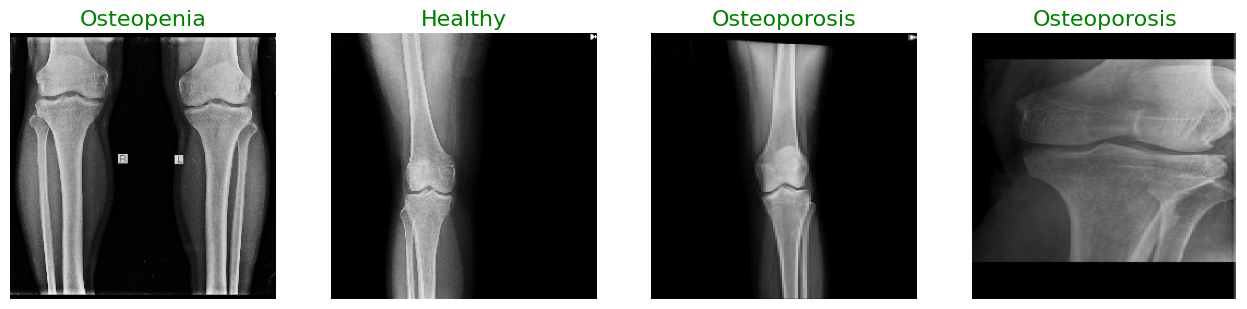

In [16]:
show_knee_images(train)

In [20]:
import tensorflow as tf
from tensorflow.keras import layers

def create_resnet(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Initial convolution layer
    x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    
    # Residual blocks
    num_res_blocks = 6
    for _ in range(num_res_blocks):
        residual = x
        
        # First convolution layer of the residual block
        x = layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        
        # Second convolution layer of the residual block
        x = layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        # Skip connection
        x = layers.add([x, residual])
        x = layers.Activation('relu')(x)

    # Additional hidden dense layer
    x = layers.Dense(128, activation='relu')(x)

    # Final layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

# Example usage
input_shape = (32, 32, 3)  # Example input shape (change it according to your data)
num_classes = 3  # Number of output classes
model = create_resnet(input_shape, num_classes)


In [22]:
# Compile the model with your choice of loss function and optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_39 (Conv2D)             (None, 16, 16, 64)   9472        ['input_4[0][0]']                
                                                                                                  
 batch_normalization_39 (BatchN  (None, 16, 16, 64)  256         ['conv2d_39[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_39 (Activation)     (None, 16, 16, 64)   0           ['batch_normalization_39[0]

In [23]:
history = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
390/390 [==============================] - 349s 879ms/step - loss: 0.9575 - accuracy: 0.5273 - val_loss: 1.3730 - val_accuracy: 0.3872
Epoch 2/10
390/390 [==============================] - 325s 834ms/step - loss: 0.8453 - accuracy: 0.5973 - val_loss: 0.8295 - val_accuracy: 0.5974
Epoch 3/10
390/390 [==============================] - 323s 828ms/step - loss: 0.7695 - accuracy: 0.6410 - val_loss: 2.2663 - val_accuracy: 0.1821
Epoch 4/10
390/390 [==============================] - 323s 829ms/step - loss: 0.7419 - accuracy: 0.6647 - val_loss: 2.1306 - val_accuracy: 0.1769
Epoch 5/10
390/390 [==============================] - 325s 834ms/step - loss: 0.7211 - accuracy: 0.6737 - val_loss: 3.5955 - val_accuracy: 0.3154
Epoch 6/10
390/390 [==============================] - 324s 830ms/step - loss: 0.7192 - accuracy: 0.6750 - val_loss: 0.7969 - val_accuracy: 0.6564
Epoch 7/10
390/390 [==============================] - 321s 823ms/step - loss: 0.6997 - accuracy: 0.6866 - val_loss: 1.5542 -

In [24]:
model.evaluate(test, verbose=1)

147/147 [==============================] - 32s 216ms/step - loss: 0.8327 - accuracy: 0.6085


[0.8326764106750488, 0.608547031879425]

In [25]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

147/147 [==============================] - 32s 215ms/step


In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

     Healthy       0.62      0.84      0.72       238
  Osteopenia       0.52      0.86      0.65       111
Osteoporosis       0.74      0.25      0.38       236

    accuracy                           0.61       585
   macro avg       0.63      0.65      0.58       585
weighted avg       0.65      0.61      0.57       585

Accuracy of the Model: 60.9%
